In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# np.random.seed(1)

In [2]:
import torch

In [3]:
import matplotlib.pyplot as plt

In [4]:
d = 6
n = 2048  #number of samples

# Function to fit

$$
\begin{eqnarray}
R &=& |\boldsymbol{x}| \\
{f} &=& \frac{\sin(4\pi R)}{4\pi R}
\end{eqnarray}
$$

In [5]:
def f(x):
    """The function to predict."""
    
    R = np.sqrt(np.sum(x**2,axis=1)) + 0.0001
    return np.sin(4*np.pi*R)/(4*np.pi*R)

In [6]:
x_train = (np.random.rand(n,d)-0.5)*2
y_train = f(x_train)

x_test = (np.random.rand(n,d)-0.5)*2
y_test = f(x_test)

x_onAxis = np.zeros([128,d])
x_onAxis[:,0] = np.linspace(-1, 1, 128)
y_onAxis = f(x_onAxis)

In [ ]:
hist = plt.hist(y_train,bins=100);
plt.xlabel('f')
plt.ylabel('count')
plt.title('train data histogram')
# plt.xlim(yPrior_train.min(),yPrior_train.max())
plt.yscale('log')
plt.tight_layout()
plt.savefig('train_data_histo_'+str(d)+'D_'+str(n)+'sample.png',dpi=180)

### GP fit

### without Prior model

In [7]:
kernel = C(1.0, (2e-2, 10.0)) * RBF(1, (2e-2, 1.0))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)

In [8]:
gp.score(x_train, y_train), gp.score(x_test, y_test)

(-4.981990371266676e-05, -6.51014860599819e-05)

In [9]:
gp.fit(x_train, y_train)
gp.kernel_

0.141**2 * RBF(length_scale=0.443)

In [10]:
gp.score(x_train, y_train), gp.score(x_test, y_test)  
# score over test data after train can become even worse when train data is not enough !!

(0.9999999999999979, -0.9595381798133014)

In [11]:
y_pred, sigma = gp.predict(x_onAxis, return_std=True)

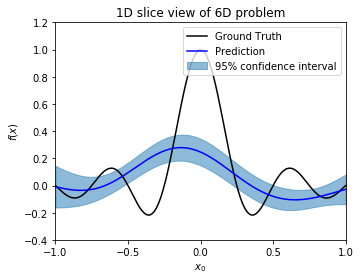

In [12]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

ax.plot(x_onAxis[:,0],y_onAxis ,'k', label='Ground Truth')
ax.plot(x_onAxis[:,0],y_pred,   'b-', label='Prediction')
ax.fill_between(x_onAxis[:,0], y_pred- 1.96 * sigma,
                               y_pred+ 1.96 * sigma, 
                label='95% confidence interval', color='C0', alpha=.5, )

plt.title('1D slice view of '+str(d)+'D problem')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.savefig('GP'+str(d)+'D_'+str(n)+'sample.png',dpi=180)

### with Prior model
$$
f_{0}(\boldsymbol{x})=f(\boldsymbol{x}) + a(\boldsymbol{x})\sin\phi(\boldsymbol{x}) + b(\boldsymbol{x})
$$

where $a(\boldsymbol{x})$, $\phi(\boldsymbol{x})$ and $b(\boldsymbol{x})$ are modeled using randomized neural network

In [13]:
amp_func = torch.nn.Sequential(torch.nn.Linear(d,256),
                              torch.nn.CELU(),
                              torch.nn.Linear(256,256),
                              torch.nn.CELU(),
                              torch.nn.Linear(256,1))

phase_func = torch.nn.Sequential(torch.nn.Linear(d,256),
                                torch.nn.CELU(),
                                torch.nn.Linear(256,256),
                                torch.nn.CELU(),
                                torch.nn.Linear(256,1))

bias_func = torch.nn.Sequential(torch.nn.Linear(d,256),
                                torch.nn.CELU(),
                                torch.nn.Linear(256,256),
                                torch.nn.CELU(),
                                torch.nn.Linear(256,1))

In [14]:
# model.state_dict()['0.weight'].copy_(model.state_dict()['0.weight']);
# model.state_dict()['0.bias'].copy_(model.state_dict()['0.bias']);
# model.state_dict()['2.weight'].copy_(model.state_dict()['2.weight']);
# model.state_dict()['2.bias'].copy_(model.state_dict()['2.bias']);

In [15]:
def f0(x):
    """The approximate function to predict."""
    f0 = f(x)
    amp = amp_func(torch.Tensor(2*x+2)).detach().numpy().ravel()
    phase = phase_func(torch.Tensor(10*x+2)).detach().numpy().ravel()
    bias = bias_func(torch.Tensor(2*x+2)).detach().numpy().ravel()
    
    return f0+0.7*(0.5*f0+amp)*np.sin(5*phase)-0.7*bias

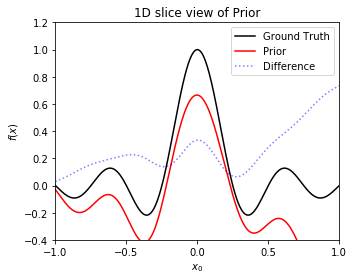

In [16]:
fig = plt.figure(figsize=(5,4))

x = np.zeros([512,d])
x[:,0] = np.linspace(-1, 1, 512)
plt.plot(x[:,0],f(x) ,'k' , label='Ground Truth')
plt.plot(x[:,0],f0(x),'r', label='Prior')
plt.plot(x[:,0],f(x)-f0(x),'b:', label='Difference',alpha=0.5)


plt.title('1D slice view of Prior')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.savefig('Prior_'+str(d)+'D_SliceView.png',dpi=180)

In [17]:
x_train = (np.random.rand(n,d)-0.5)*2
y_train = f(x_train) -f0(x_train)

x_test = (np.random.rand(n,d)-0.5)*2
y_test = f(x_test) -f0(x_test)

x_onAxis = np.zeros([128,d])
x_onAxis[:,0] = np.linspace(-1, 1, 128)
y_onAxis = f(x_onAxis)

In [18]:
kernel = C(1.0, (2e-2, 10.0)) * RBF(1, (2e-2, 10.0))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [19]:
gp.score(x_train, y_train), gp.score(x_test, y_test)

(-1.0968654040359405, -1.0636123434020748)

In [20]:
gp.fit(x_train, y_train)
gp.kernel_

0.288**2 * RBF(length_scale=0.383)

In [21]:
gp.score(x_train, y_train), gp.score(x_test, y_test)  
# score over test data after train can become even worse when train data is not enough !!

(1.0, 0.3854697379869445)

In [22]:
y_pred, sigma = gp.predict(x_onAxis, return_std=True)

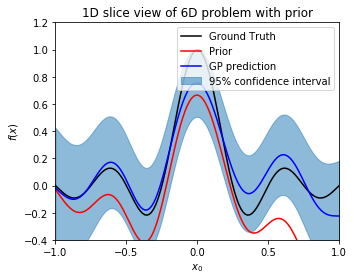

In [23]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

ax.plot(x_onAxis[:,0],y_onAxis           ,'k' , label='Ground Truth')
ax.plot(x_onAxis[:,0],f0(x_onAxis)       ,'r', label='Prior')
ax.plot(x_onAxis[:,0],f0(x_onAxis)+y_pred,'b-', label='GP prediction')
ax.fill_between(x_onAxis[:,0], 
                f0(x_onAxis)+y_pred- 1.96 * sigma,
                f0(x_onAxis)+y_pred+ 1.96 * sigma, 
                label='95% confidence interval', color='C0', alpha=.5, )

plt.title('1D slice view of '+str(d)+'D problem with prior')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.savefig('GP_wPrior_'+str(d)+'D_'+str(n)+'sample.png',dpi=180)